# Assignment 5: Local Features and Image Matching
Tổng quan: 

Ở bài tập này, chúng ta sẽ thực hiện trích xuất một số đặc trưng cơ bản từ ảnh (toàn cục, cục bộ). So khớp các đặc trưng cục bộ để tìm đối tượng trong ảnh, cũng như sử dụng đặc trưng cục bộ để ghép ảnh.

- Harris Corner
- Histogram of Oriented Gradients (HOG)
- Difference of Gaussians (DoG)
- Scale-Invariant Feature Transform (SIFT)
- Local feature matching 
- Panorama Stitching sử dụng Stitcher trong OpenCV

Yêu cầu thư viện: OpenCV 3.4.2.17 , matplotlib, skimage, opencv-contrib-python 3.4.2.17

(pip uninstall opencv-python
pip uninstall opencv-contrib-python
pip install opencv-contrib-python==3.4.2.17)

In [1]:
from IPython.display import Image
from skimage.feature import hog

import skimage
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import imutils

ModuleNotFoundError: No module named 'cv2'

## I. Harris Corner Detector
Harris Corner là một phương pháp phát hiện các điểm (có tính chất) góc trong ảnh, thường được sử dụng khi tính toán các đặc trưng ảnh cho các bài toán thị giác máy tính.


Thư viện OpenCV cung cấp hàm cv2.cornerHarris() để phát hiện các điểm góc trong ảnh. Tham số như sau:
- img - Ảnh đầu vào, phải ở dạng grayscale và float32
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of Sobel derivative used.
- k - Harris detector free parameter in the equation.

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html


### Hãy hoàn thành hàm detect_corner(), với các tham số sau:

Input:
- image_path: Đường dẫn file ảnh
- blockSize, ksize, k: tham số của hàm cv2.cornerHarris()
- threshold: ngưỡng để coi 1 điểm là góc

Output:
- Đường dẫn tới file ảnh đầu ra

In [2]:
def detect_corner(image_path, blockSize=2, ksize=3, k=0.04, threshold=0.01):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,blockSize,ksize,k)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>threshold*dst.max()]=[0,0,255]
    
    # output file
    relative_path, image_basename = os.path.split(image_path)
    output_file = os.path.join(relative_path, 'corner_'+image_basename)
    
    cv2.imwrite(output_file,img)
    return output_file

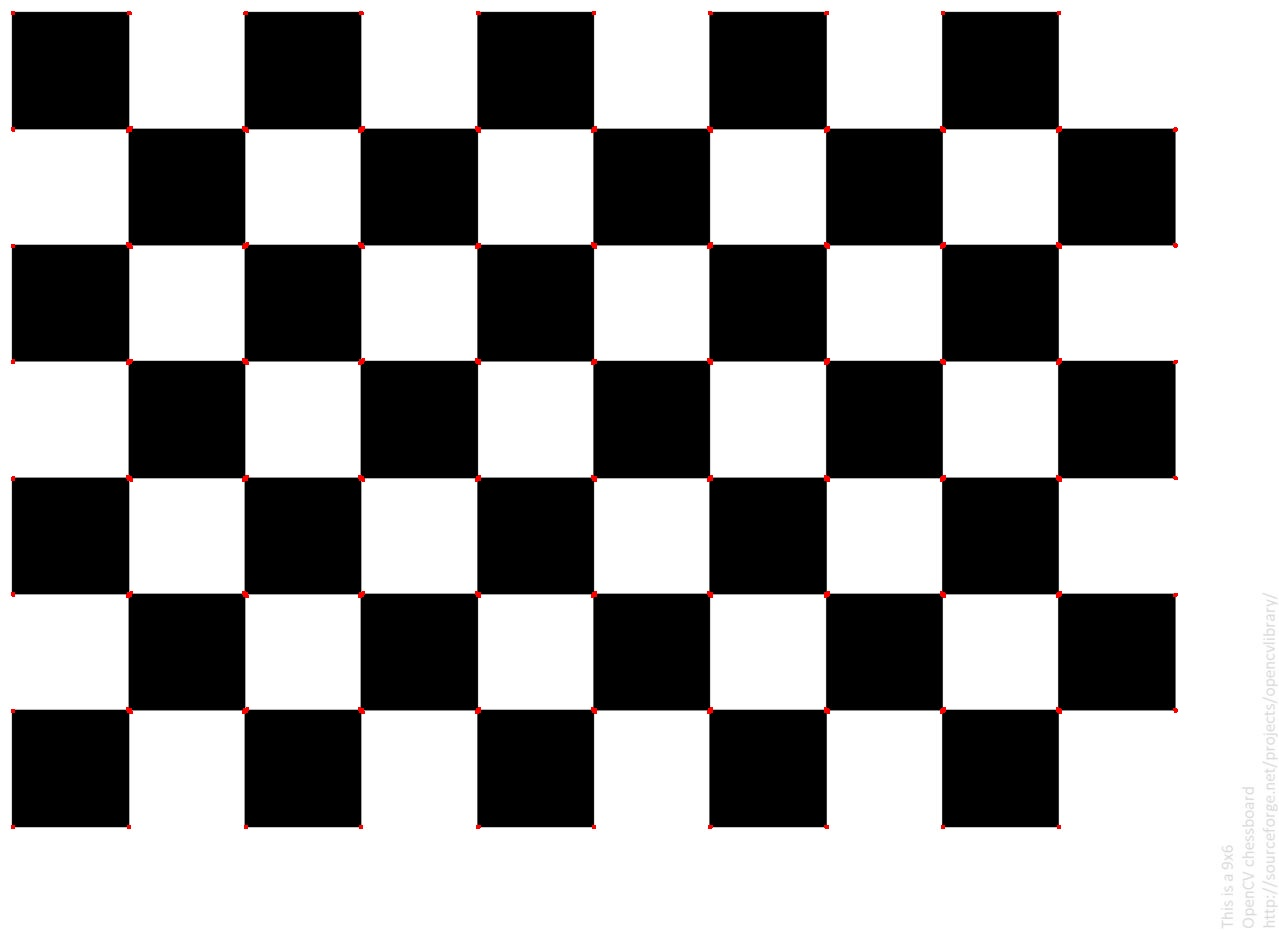

In [3]:
out_path = detect_corner('images/chessboard.jpg')
#out_path = detect_corner('sudoku.png')
Image(out_path)

### Hãy thử tùy chỉnh tham số của hàm detect_corner() với ảnh 'house.jpg' và 'sudoku.png' sau sao cho ảnh đầu ra phát hiện được nhiều góc chính xác nhất.

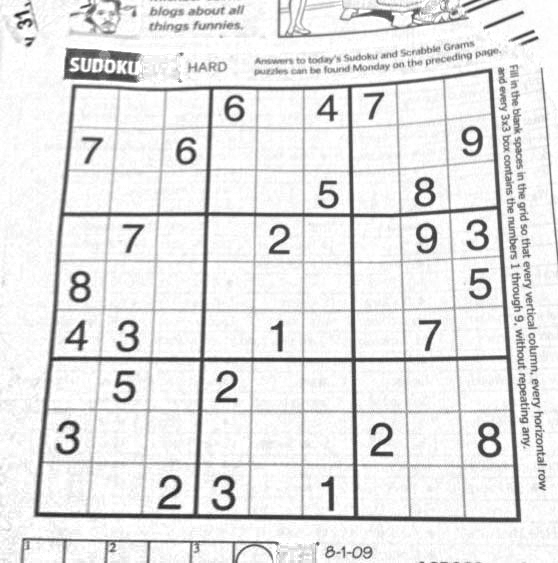

In [4]:
Image('images/sudoku.png')

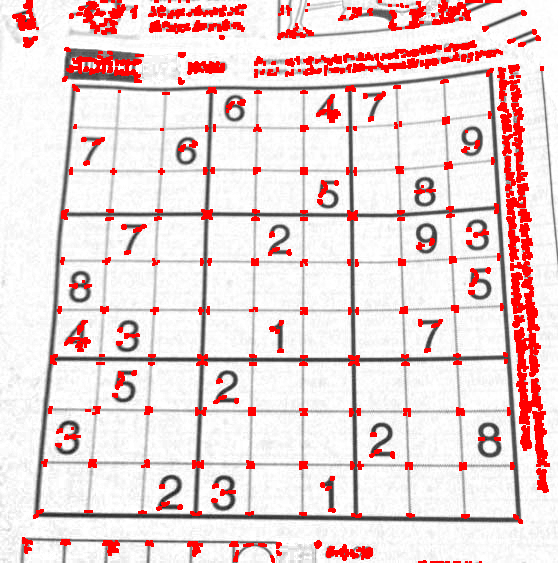

In [5]:
### YOUR CODE HERE
out_path = detect_corner('images/sudoku.png', blockSize=2, ksize=5, k=0.04, threshold=0.005)
### YOUR CODE HERE
Image(out_path)

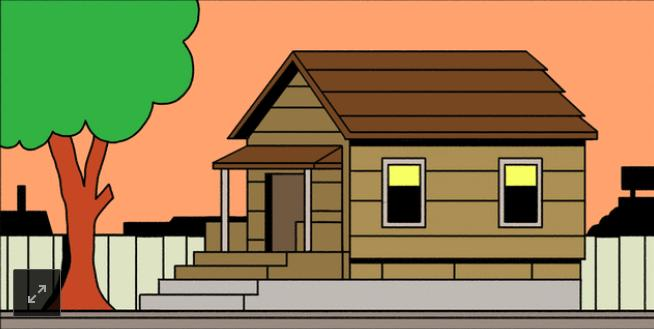

In [6]:
Image('images/house.jpg')

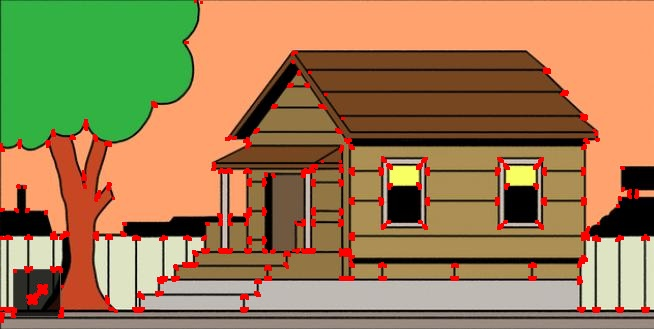

In [7]:
### YOUR CODE HERE
out_path = detect_corner('images/house.jpg', blockSize=2, ksize=5, k=0.04, threshold=0.005)
### YOUR CODE HERE
Image(out_path)

## II. Histogram of Oriented Gradients (HOG) - Ví dụ đặc trưng toàn cục
Histogram of Oriented Gradients (HOG) là bộ mô tả đặc trưng thường được sử dụng để biểu diễn đối tượng trong ảnh.

Thư viện scikit-image (skimage) cung cấp hàm skimage.feature.hog() để trích chọn đặc trưng HOG. Một số tham số quan trọng của hàm như sau:
- orientations: Number of orientation bins.
- pixels_per_cell: Size (in pixels) of a cell.
- cells_per_block: Number of cells in each block.

Xem đầy đủ tại: http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

Tutorial chi tiết về HOG: https://www.learnopencv.com/histogram-of-oriented-gradients/

(3696,)
(348, 352, 3)


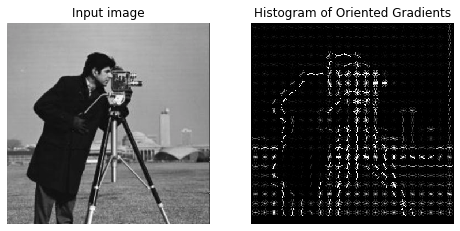

In [8]:
image = cv2.imread('images/man.png')

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
# Descriptor shape 
print(fd.shape)
print(image.shape)

# Show des inout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = skimage.exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## III. Scale-Invariant Feature Transform (SIFT) - Đặc trưng cục bộ: 
- Phát hiện các điểm đặc trưng sử dụng DoG
- Bộ mô tả các điểm đặc trưng SIFT

Thư viện OpenCV cung cấp các hàm liên quan đến trích chọn đặc trưng SIFT: 
https://docs.opencv.org/3.4/d5/d3c/classcv_1_1xfeatures2d_1_1SIFT.html. 
Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create(). Từ bản 4.4, vấn đề bản quyền của sift được gỡ, khởi tạo đối tượng sift sử dụng lệnh sift = cv2.SIFT_create() https://docs.opencv.org/4.4.0/d7/d60/classcv_1_1SIFT.html

Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. 

Chúng ta có thể dùng các đặc trưng cho bài toán phát hiện đổi tượng và phân loại ảnh

Number of keypoints: 878
(2.8765830993652344, 204.2153778076172)
2.3521878719329834
119.755615234375
Descriptor shape =  (878, 128)
Descriptor size =  128


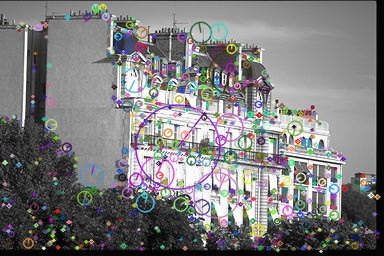

In [9]:
img = cv2.imread('images/ville01002.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create() #up to version OpenCV 3.4.2: (pip uninstall opencv-python pip uninstall opencv-contrib-python pip install opencv-contrib-python==3.4.2.17)
#sift = cv2.SIFT_create() ; # from OpenCV 4.0 (?4.5)

kp, des = sift.detectAndCompute(gray,None)

print('Number of keypoints:', len(kp))
print(kp[0].pt)
print(kp[0].size)
print(kp[0].angle)

print('Descriptor shape = ', des.shape)
print('Descriptor size = ', sift.descriptorSize())

#img=cv2.drawKeypoints(gray,kp,img)
img=cv2.drawKeypoints(gray,kp,img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#img_final = cv2.drawKeypoints(img, keypoint, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('sift_keypoints.jpg',img)
Image('sift_keypoints.jpg')

## IV. Speeded-Up Robust Features (SURF) - Đặc trưng cục bộ
(Nhanh hơn SIFT)
- Phát hiện điểm đặc trưng
- Bộ mô tả điểm đặc trưng SURF

Nếu phiên bản đang sử dụng có lỗi phần này, tạm thời bỏ qua nó và xem lại cài đặt bổ sung sau

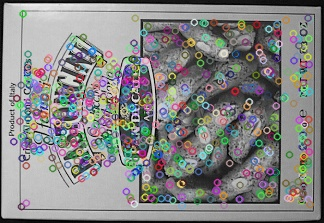

In [10]:
img = cv2.imread('images/box.png', 0)

minHessian = 400
detector = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian) 
keypoints = detector.detect(img) # các điểm đặc trưng

#-- Draw keypoints
img_keypoints = np.empty((img.shape[0], img.shape[1], 3), dtype=np.uint8)
cv2.drawKeypoints(img, keypoints, img_keypoints)
#cv2.drawKeypoints(img, keypoints, img_keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('surf_keypoints.jpg',img_keypoints)
Image('surf_keypoints.jpg')

# More Ref: https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html

## V. Image Matching sử dụng đặc trưng cục bộ SIFT

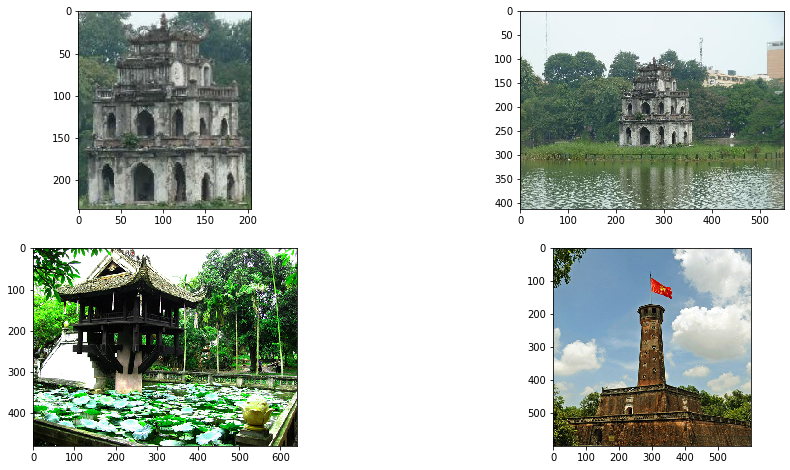

In [11]:
img1 = cv2.imread('images/thaprua.jpg')
img2 = cv2.imread('images/thaprua2.jpg')
img3 = cv2.imread('images/chuamotcot.jpg')
img4 = cv2.imread('images/cotco.jpg')

img1_ = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_ = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_ = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4_ = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,8))

plt.subplot(221), plt.imshow(img1_)
plt.subplot(222), plt.imshow(img2_)
plt.subplot(223), plt.imshow(img3_)
plt.subplot(224), plt.imshow(img4_) 
plt.show()

In [12]:
# tạo bộ trích chọn đặc trưng
sift = cv2.xfeatures2d.SIFT_create()

# tìm điểm đặc trưng và tính sift cho từng ảnh
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
kp3, des3 = sift.detectAndCompute(img3,None)
kp4, des4 = sift.detectAndCompute(img4,None)

- FLANN là viết tắt của Fast Library for Approximate Nearest Neighbors. Nó chứa một bộ sưu tập các thuật toán được tối ưu hóa để tìm kiếm hàng xóm gần nhất nhanh chóng trong bộ dữ liệu lớn
https://github.com/flann-lib/flann
http://opencv.jp/opencv-2svn_org/cpp/flann_fast_approximate_nearest_neighbor_search.html

In [13]:
## tìm các cặp đặc trưng tương đồng giữa 2 ảnh. Có thể sử dụng phương pháp vét cạn BRUTE_FORCE matching hoặc FLANN hỗ trợ so khớp nhanh hơn
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches2 = flann.knnMatch(des1,des2,k=2) # trả về 2 features gần nhất từ tập des2

MIN_MATCH_COUNT=10
good = []
distance_ratio = 0.7
for m,n in matches2:
    if m.distance < distance_ratio*n.distance: # chỉ giữ lại những ghép cặp ổn định (m.distance: khoảng cách gần nhất, n.distance: khoảng cách gần thứ 2)
        good.append(m)

Sử dụng thuật toán RANSAC hoặc LEAST_MEDIAN từ hàm cv2.findHomography để chỉ định vùng object xác định

In [14]:
## khoanh vùng đối tượng tương ứng được tìm thấy
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    # tìm phép biến đổi đồng dạng giữa 2 tập điểm được so khớp
    ### YOUR CODE HERE
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) 
    ### YOUR CODE HERE
    
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    
    # xác định vị trí tương ứng trên ảnh đích của 4 góc trên ảnh nguồn
    
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # 4 điểm khoanh vùng trên ảnh nguồn
    ### YOUR CODE HERE
    dst = cv2.perspectiveTransform(pts,M) # thực hiện biến đổi để tìm ra vị trí tương ứng trong ảnh được so khớp
    ### YOUR CODE HERE
    
    # hiển thị kết quả tương ứng
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

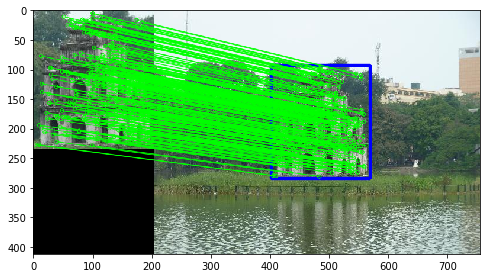

In [15]:
## hiển thị kết quả
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img12 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img12, cv2.COLOR_BGR2RGB))
plt.show()

## Hãy thực hiện so khớp giữa các cặp ảnh khác (img1, img3) và (img1, img4)

Học viên có thể viết lại dưới dạng hàm để sử dụng cho gọn

In [16]:
def ImageMatching(img1, img2, distance_ratio):
    
    ### YOUR CODE HERE
    
    # tạo bộ trích chọn đặc trưng
    sift = cv2.xfeatures2d.SIFT_create()

    # tìm điểm đặc trưng và tính sift cho từng ảnh
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    ## tìm các cặp đặc trưng tương đồng giữa 2 ảnh. Có thể sử dụng phương pháp vét cạn BRUTE_FORCE matching hoặc FLANN hỗ trợ so khớp nhanh hơn
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches2 = flann.knnMatch(des1,des2,k=2) # trả về 2 features gần nhất từ tập des2
    
    MIN_MATCH_COUNT=10
    good = []
    for m,n in matches2:
        if m.distance < distance_ratio*n.distance: # chỉ giữ lại những ghép cặp ổn định (m.distance: khoảng cách gần nhất, n.distance: khoảng cách gần thứ 2)
            good.append(m)
        
    ## khoanh vùng đối tượng tương ứng được tìm thấy
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0) # tìm phép biến đổi đồng dạng giữa 2 tập điểm được so khớp
        matchesMask = mask.ravel().tolist()
        h,w,d = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # 4 điểm khoanh vùng trên ảnh nguồn
        dst = cv2.perspectiveTransform(pts,M) # thực hiện biến đổi để tìm ra vị trí tương ứng trong ảnh được so khớp
        img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None    
    
    ## hiển thị kết quả
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    img12 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img12, cv2.COLOR_BGR2RGB))
    plt.show()    
    
    ### YOUR CODE HERE

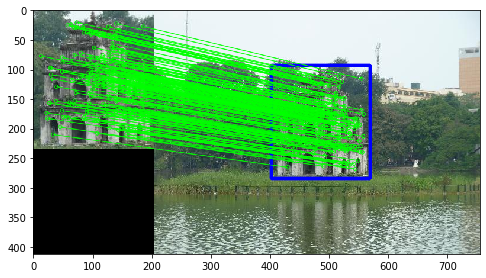

In [17]:
 ImageMatching(img1, img2, 0.4)

Not enough matches are found - 4/10


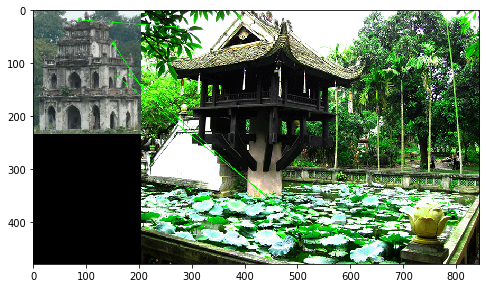

In [18]:
 ImageMatching(img1, img3, 0.7)

Not enough matches are found - 1/10


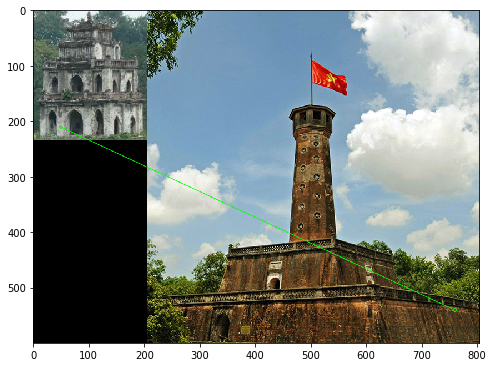

In [19]:
 ImageMatching(img1, img4, 0.7)

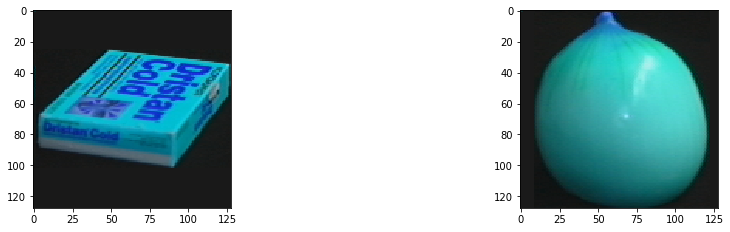

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\core\src\matmul.cpp:2268: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [22]:
imgA = cv2.imread('../CV05bis.CBIR/query/obj1__110.png')
imgB = cv2.imread('../CV05bis.CBIR/database/obj2__40.png')

plt.figure(figsize=(16,8))
plt.subplot(221), plt.imshow(imgA)
plt.subplot(222), plt.imshow(imgB)
plt.show()

ImageMatching(imgA, imgB, 0.7)


### Thực hiện ghép cặp 1 cặp ảnh sử dụng đặc trưng cục bộ SURF

In [ ]:
### YOUR CODE HERE

### YOUR CODE HERE

## VI. Panorama Stitching

Ứng dụng tạo ảnh Panorama dựa trên đặc trưng cục bộ. Tuy nhiên, để tạo ảnh đẹp hoàn chỉnh thì cần nhiều bước. Stitcher được cài đặt trong OpenCV.

Ref: http://matthewalunbrown.com/papers/ijcv2007.pdf

In [ ]:
Image('images/StitchingPipeline.jpg')

In [ ]:
imageA = cv2.imread('./panorama/mountain1_left.png')
imageB = cv2.imread('./panorama/mountain1_right.png')

plt.figure(figsize=(16,16))
plt.subplot(121), plt.imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# stitcher = cv2.createStitcher('SCANS', False)
stitcher = cv2.createStitcher(False)
#stitcher = cv2.Stitcher.create()
result = stitcher.stitch((imageA, imageB))
stitched=result[1]
cv2.imwrite('mountain1.png', result[1])

# Image('mountain1.png')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.show()

### Xử lý viền ngoài ảnh

In [ ]:
# create a 10 pixel border surrounding the stitched image
stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,cv2.BORDER_CONSTANT, (0, 0, 0)) 

# convert the stitched image to grayscale and threshold it
# such that all pixels greater than zero are set to 255
# (foreground) while all others remain 0 (background)
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# find all external contours in the threshold image then find
# the *largest* contour which will be the contour/outline of
# the stitched image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# allocate memory for the mask which will contain the rectangular bounding box of the stitched image region
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

# create two copies of the mask: one to serve as our actual
# minimum rectangular region and another to serve as a counter
# for how many pixels need to be removed to form the minimum
# rectangular region
minRect = mask.copy()
sub = mask.copy()
while cv2.countNonZero(sub) > 0:
    # erode the minimum rectangular mask and then subtract
	# the thresholded image from the minimum rectangular mask
	# so we can count if there are any non-zero pixels left
    minRect = cv2.erode(minRect, None)
    sub = cv2.subtract(minRect, thresh)
    
# find contours in the minimum rectangular mask and then
# extract the bounding box (x, y)-coordinates    
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)

# use the bounding box coordinates to extract the our final
# stitched image
stitched = stitched[y:y + h, x:x + w]

# write the output stitched image to disk
cv2.imwrite('mountain1_stic.png', stitched)

#Image('mountain1_stic.png')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.show()

## Thực hành với cặp ảnh khác

Học viên nên viết dưới dạng hàm để gọi lại

In [ ]:
imageA = cv2.imread('./panorama/scottsdale_left.png')
imageB = cv2.imread('./panorama/scottsdale_right.png')

plt.figure(figsize=(16,16))
plt.subplot(121), plt.imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
### YOUR CODE HERE
## Ghép ảnh
stitcher = cv2.createStitcher(False)
#stitcher = cv2.Stitcher.create()

result = stitcher.stitch((imageA, imageB))
stitched=result[1]

cv2.imwrite('scottsdale.png', result[1])
#Image('scottsdale.png')

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.show()
### YOUR CODE HERE

In [ ]:
## xử lý cắt viền ngoài
### YOUR CODE HERE

stitched = cv2.copyMakeBorder(stitched, 10, 10, 10, 10,cv2.BORDER_CONSTANT, (0, 0, 0))
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
minRect = mask.copy()
sub = mask.copy()
while cv2.countNonZero(sub) > 0:
    minRect = cv2.erode(minRect, None)
    sub = cv2.subtract(minRect, thresh)
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)
stitched = stitched[y:y + h, x:x + w]
cv2.imwrite('scottsdale.png', stitched)

#Image('scottsdale.png')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.show()

### YOUR CODE HERE